In [1]:
import tensorflow as tf
import tensornetwork as tn
import numpy as np
import tensornetwork as tn
class TNLayer(tf.keras.layers.Layer):
 
  def __init__(self,Tensor_dimention = 20):
    super(TNLayer, self).__init__()
    # Create the variables for the layer.
    

    self.A1 = tf.Variable(tf.random.normal(shape=[4,Tensor_dimention,4], stddev=1.0/192.0),name="a1", trainable=True)
    self.A2 = tf.Variable(tf.random.normal(shape=[4,Tensor_dimention,Tensor_dimention,4], stddev=1.0/192.0),name="a2", trainable=True)
    self.A3 = tf.Variable(tf.random.normal(shape=[4,Tensor_dimention,Tensor_dimention,4], stddev=1.0/192.0),name="a3", trainable=True)
    self.A4 = tf.Variable(tf.random.normal(shape=[4,Tensor_dimention,3], stddev=1.0/192.0),name="a4", trainable=True)
    Nodes = [tn.Node(self.A1,'a0',backend="tensorflow")]
    Nodes+=[tn.Node(self.A2,f'a{1}',backend="tensorflow")]
    Nodes+=[tn.Node(self.A3,f'a{2}',backend="tensorflow")]
    Nodes+=[tn.Node(self.A4,f'a{3}',backend="tensorflow")]
    self.Nodes = Nodes

    self.bias = tf.Variable(tf.zeros(shape=(192)), name="bias", trainable=True)
 
  def call(self, inputs):
    # Define the contraction.
    # We break it out so we can parallelize a batch using
    # tf.vectorized_map (see below).
    def f(input_vec, Nodes, bias_var):
      # Reshape to a matrix instead of a vector.
      input_vec = tf.reshape(input_vec, [200,4,4,4,4])
      T_node = tn.Node(input_vec, backend="tensorflow",name = 't')
      for i in range(len(Nodes)-1):
        if i == 0:
          Nodes[i][1]^Nodes[i+1][1]
        else:
          Nodes[i][2]^Nodes[i+1][1]
      for i in range(len(Nodes)):
        Nodes[i][0]^T_node[i+1]    
      
      contraction = T_node@Nodes[0]
      for i in range(1,len(Nodes)):
        contraction = contraction@Nodes[i]
      result = tf.reshape(contraction.tensor,[200,192])

      # To make the code shorter, we also could've used Ncon.
      # The above few lines of code is the same as this:
      # result = tn.ncon([x, a_var, b_var], [[1, 2], [-1, 1, 3], [-2, 2, 3]])
 
      # Finally, add bias.
      return result + bias_var
  
    # To deal with a batch of items, we can use the tf.vectorized_map
    # function.
    # https://www.tensorflow.org/api_docs/python/tf/vectorized_map
    result = tf.vectorized_map(
        lambda vec: f(vec, self.Nodes, self.bias), inputs)
    return result

2023-12-21 19:58:38.601955: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-21 19:58:39.100494: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-21 19:58:40.870381: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.8/lib64:/usr/local/cuda-11.3/lib64
2023-12-21 19:58:40.870508: W te

In [131]:
import tensorflow as tf
import tensornetwork as tn
import numpy as np
import tensornetwork as tn
Tensor_dimention = 20
T_node = tn.Node(tf.random.normal(shape=[32,200,4,4,4,4]),'input',backend='tensorflow',axis_names=['batch','sequence','emb1','emb2','emb3','emb4'])
A1 = tf.Variable(tf.random.normal(shape=[4,Tensor_dimention,4], stddev=1.0/192.0),name="a1", trainable=True)
A2 = tf.Variable(tf.random.normal(shape=[4,Tensor_dimention,Tensor_dimention,4], stddev=1.0/192.0),name="a2", trainable=True)
A3 = tf.Variable(tf.random.normal(shape=[4,Tensor_dimention,Tensor_dimention,4], stddev=1.0/192.0),name="a3", trainable=True)
A4 = tf.Variable(tf.random.normal(shape=[4,Tensor_dimention,3], stddev=1.0/192.0),name="a4", trainable=True)
Nodes = [tn.Node(A1,'a0',backend="tensorflow",axis_names=['input','con0','output'])]
Nodes+=[tn.Node(A2,f'a{1}',backend="tensorflow",axis_names=['input','con1','con2','output'])]
Nodes+=[tn.Node(A3,f'a{2}',backend="tensorflow",axis_names=['input','con3','con4','output'])]
Nodes+=[tn.Node(A4,f'a{3}',backend="tensorflow",axis_names=['input','con5','output'])]

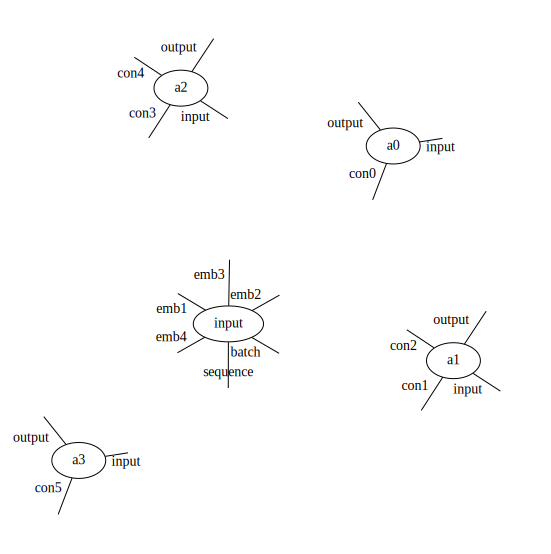

In [132]:
tn.to_graphviz([T_node]+Nodes,)

In [133]:
for i in range(len(Nodes)-1):
    if i == 0:
        Nodes[i][1]^Nodes[i+1][1]
    else:
        Nodes[i][2]^Nodes[i+1][1]

In [134]:
for i in range(len(Nodes)):
    T_node[i+2]^Nodes[i][0]

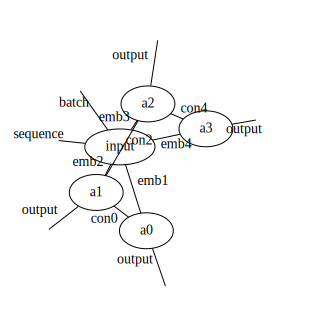

In [135]:
tn.to_graphviz([T_node]+Nodes,)

In [136]:
cont = T_node@Nodes[0]

In [140]:
cont =cont @Nodes[1]

In [142]:
cont.shape

(32, 200, 4, 4, 4, 20, 4)

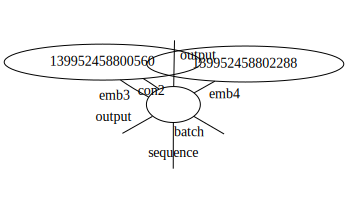

In [143]:
tn.to_graphviz([cont])

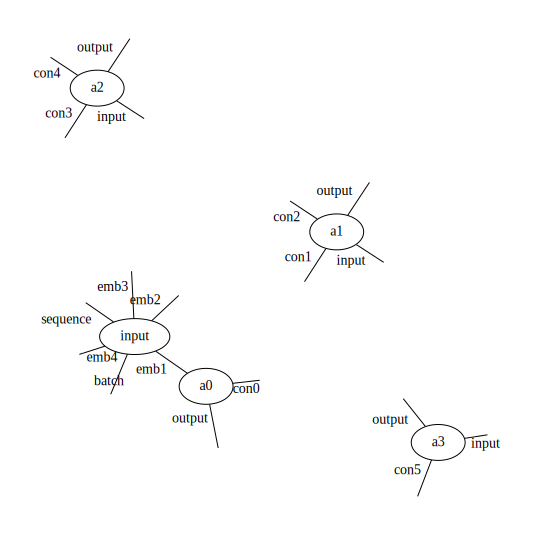

In [75]:
tn.to_graphviz([T_node]+Nodes)

In [49]:
TN = TNLayer()
A = np.random.random([200,256])

In [50]:
TN(np.array([A,A,A,A,A]))

<tf.Tensor: shape=(5, 200, 192), dtype=float32, numpy=
array([[[-1.76473222e-07, -2.09265735e-07,  7.39498830e-07, ...,
         -2.46141212e-07, -4.91976607e-07, -2.20541722e-07],
        [-4.70632216e-07,  1.96382473e-07,  6.70125814e-07, ...,
         -2.51511494e-07,  5.84928443e-08, -2.76010695e-07],
        [-4.30301185e-07, -5.17214914e-07,  2.57740169e-07, ...,
         -9.67300025e-07,  1.27597076e-07,  1.60715715e-07],
        ...,
        [ 1.22441492e-07, -3.13303929e-07,  4.55734607e-07, ...,
         -8.24273741e-07,  2.66894688e-07, -1.89861552e-07],
        [-1.18806774e-07,  1.51035749e-07,  2.93237520e-07, ...,
         -3.77316418e-08,  6.13446559e-07, -2.28804339e-07],
        [-2.27619466e-07, -1.52075927e-07, -3.76411080e-08, ...,
         -6.16560758e-09, -1.70559659e-07, -1.19754844e-07]],

       [[-1.76473222e-07, -2.09265735e-07,  7.39498830e-07, ...,
         -2.46141212e-07, -4.91976607e-07, -2.20541722e-07],
        [-4.70632216e-07,  1.96382473e-07,  6.70

In [51]:
import tensorflow as tf

class MultiheadAttention_tensor(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads,classical_rate = 0.25,Tensor_dimention = 20):
        super(MultiheadAttention, self).__init__()
        assert d_model % num_heads == 0
        self.num_heads = num_heads
        self.depth = d_model // num_heads
        self.rate = classical_rate
        assert int(num_heads/classical_rate) == num_heads/classical_rate



        self.wq = tf.keras.layers.Dense(int(d_model*classical_rate))
        self.wk = tf.keras.layers.Dense(int(d_model*classical_rate))
        self.wv = tf.keras.layers.Dense(int(d_model*classical_rate))

        self.wq_tensor = TNLayer(Tensor_dimention)
        self.wk_tensor = TNLayer(Tensor_dimention)
        self.wv_tensor = TNLayer(Tensor_dimention)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, int(self.num_heads*self.rate), self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    def split_heads_tensor(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, int(self.num_heads*(1-self.rate)), self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    def call(self, q, k, v, mask):
        batch_size = tf.shape(q)[0]
        
        print(q.shape)
        q_class = self.split_heads(self.wq(q), batch_size)
        k_class = self.split_heads(self.wk(k), batch_size)
        v_class = self.split_heads(self.wv(v), batch_size)
        print(q_class.shape)
        q_tensor = self.split_heads_tensor(self.wq_tensor(q),batch_size)
        k_tensor = self.split_heads_tensor(self.wq_tensor(k),batch_size)
        v_tensor = self.split_heads_tensor(self.wq_tensor(v),batch_size)
        q,k,v = tf.concat([q_class,q_tensor],axis=1),tf.concat([k_class,k_tensor],axis=1),tf.concat([v_class,v_tensor],axis=1)

        scaled_attention, attention_weights = self.scaled_dot_product_attention(q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, d_model))

        output = self.dense(concat_attention)
        return output, attention_weights

    def scaled_dot_product_attention(self, q, k, v, mask):
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

        if mask is not None:
            scaled_attention_logits += (mask * -1e9)

        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        output = tf.matmul(attention_weights, v)
        return output, attention_weights

# 테스트
d_model = 256
num_heads = 8
input_seq_len = 200
batch_size = 48

multihead_attention = MultiheadAttention(d_model, num_heads,Tensor_dimention=15)
input_q = tf.random.normal((batch_size, input_seq_len, d_model))
input_k = tf.random.normal((batch_size, input_seq_len, d_model))
input_v = tf.random.normal((batch_size, input_seq_len, d_model))
mask = None  # Optional mask to specify which positions should be masked
output, attention_weights = multihead_attention(input_q, input_k, input_v, mask)
print("Multihead Attention Output shape:", output.shape)
print("Attention Weights shape:", attention_weights.shape)

(48, 200, 256)
(48, 2, 200, 32)
Multihead Attention Output shape: (48, 200, 256)
Attention Weights shape: (48, 8, 200, 200)


: 

In [21]:
multihead_attention.count_params()

138572

In [22]:
import tensorflow as tf

class MultiheadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiheadAttention, self).__init__()
        assert d_model % num_heads == 0
        self.num_heads = num_heads
        self.depth = d_model // num_heads
        
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, q, k, v, mask):
        batch_size = tf.shape(q)[0]

        q = self.split_heads(self.wq(q), batch_size)
        k = self.split_heads(self.wk(k), batch_size)
        v = self.split_heads(self.wv(v), batch_size)
        print(q.shape)

        scaled_attention, attention_weights = self.scaled_dot_product_attention(q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, d_model))

        output = self.dense(concat_attention)
        return output, attention_weights

    def scaled_dot_product_attention(self, q, k, v, mask):
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

        if mask is not None:
            scaled_attention_logits += (mask * -1e9)

        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        output = tf.matmul(attention_weights, v)
        return output, attention_weights

# 테스트
d_model = 256
num_heads = 8
input_seq_len = 200
batch_size = 4096

multihead_attention = MultiheadAttention(d_model, num_heads)
input_q = tf.random.normal((batch_size, input_seq_len, d_model))
input_k = tf.random.normal((batch_size, input_seq_len, d_model))
input_v = tf.random.normal((batch_size, input_seq_len, d_model))
mask = None  # Optional mask to specify which positions should be masked

output, attention_weights = multihead_attention(input_q, input_k, input_v, mask)
print("Multihead Attention Output shape:", output.shape)
print("Attention Weights shape:", attention_weights.shape)

(4096, 8, 200, 32)
Multihead Attention Output shape: (4096, 200, 256)
Attention Weights shape: (4096, 8, 200, 200)


In [8]:
multihead_attention.trainable_variables[1]

<tf.Variable 'multihead_attention_1/dense_4/bias:0' shape=(256,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.

In [9]:
multihead_attention.count_params()

263168